In [33]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv("gld_price_data.csv")

# Display the first few rows
df.head()



,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


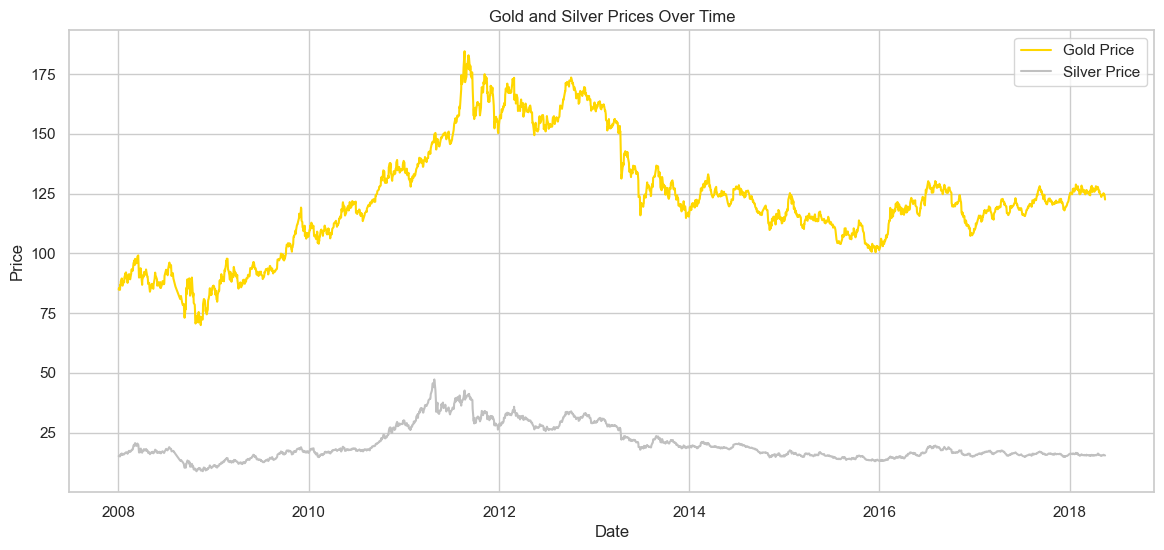

In [34]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot gold and silver prices over time
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['GLD'], label='Gold Price', color='gold')
plt.plot(df['Date'], df['SLV'], label='Silver Price', color='silver')
plt.title('Gold and Silver Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [35]:
# Create the Gold-Silver Price Ratio
df['Gold_Silver_Ratio'] = df['GLD'] / df['SLV']

# Create moving averages and volatility measures
df['Gold_5_MA'] = df['GLD'].rolling(window=5).mean()
df['Silver_5_MA'] = df['SLV'].rolling(window=5).mean()
df['Gold_20_MA'] = df['GLD'].rolling(window=20).mean()
df['Silver_20_MA'] = df['SLV'].rolling(window=20).mean()
df['Gold_Volatility'] = df['GLD'].rolling(window=5).std()
df['Silver_Volatility'] = df['SLV'].rolling(window=5).std()

# Drop rows with NaN values generated by rolling calculations
df.dropna(inplace=True)
df.head()


,Date,SPX,GLD,USO,SLV,EUR/USD,Gold_Silver_Ratio,Gold_5_MA,Silver_5_MA,Gold_20_MA,Silver_20_MA,Gold_Volatility,Silver_Volatility
19,2008-01-30,1355.810059,92.059998,73.080002,16.674999,1.483107,5.520840,91.068001,16.471399,88.0020,15.88035,0.869176,0.166580
20,2008-01-31,1378.550049,91.400002,72.349998,16.818001,1.486503,5.434653,91.332001,16.575000,88.3290,15.96225,0.672211,0.192409
21,2008-02-01,1395.420044,89.349998,70.470001,16.618999,1.479991,5.376377,91.142000,16.639200,88.5180,16.02895,1.059515,0.114764
22,2008-02-04,1380.819946,89.099998,71.370003,16.514999,1.482800,5.395096,90.612000,16.632200,88.7165,16.09635,1.312049,0.122380
23,2008-02-05,1336.640015,87.680000,70.150002,16.167000,1.463807,5.423393,89.917999,16.558800,88.8620,16.15205,1.787798,0.244815


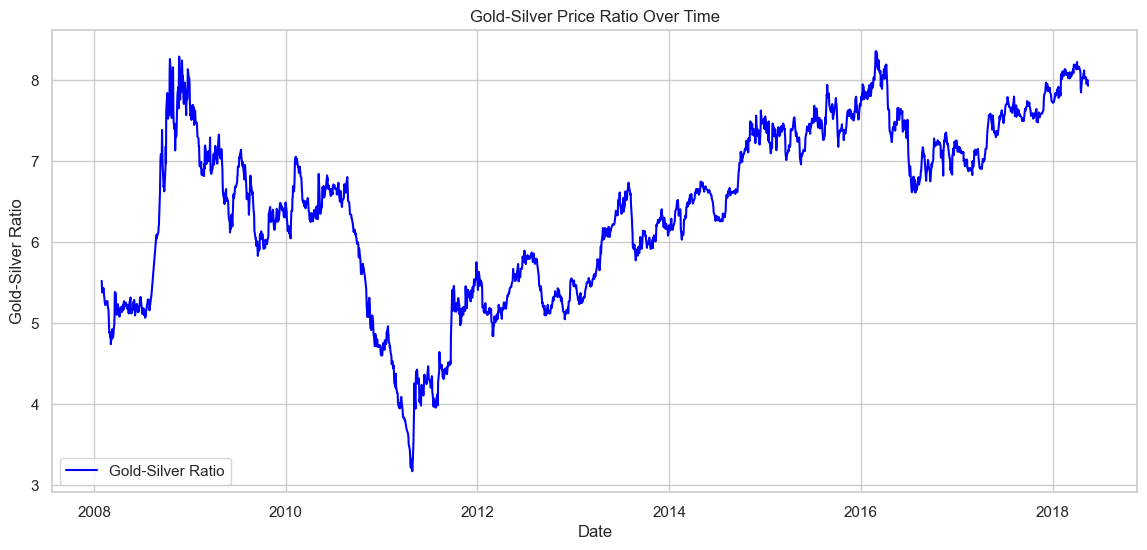

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Gold_Silver_Ratio'], color='blue', label='Gold-Silver Ratio')
plt.title('Gold-Silver Price Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Gold-Silver Ratio')
plt.legend()
plt.show()


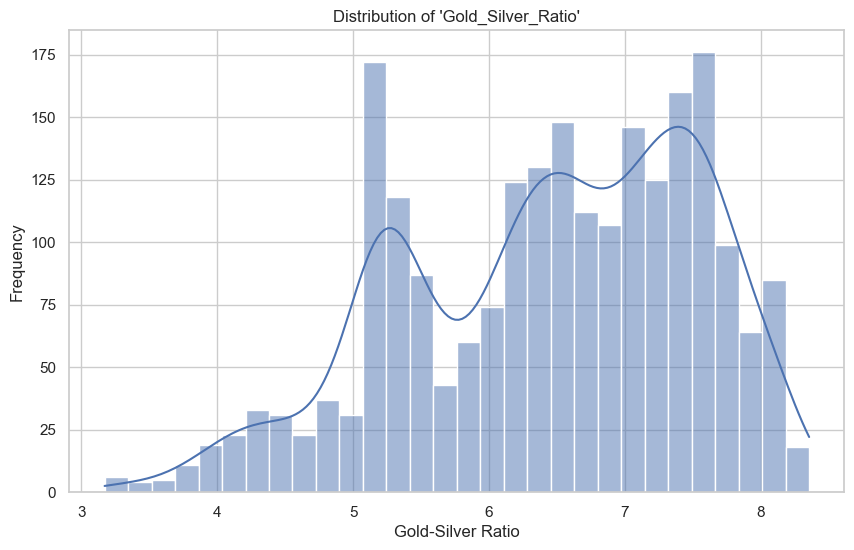

Value counts for 'Swap_Gold_for_Silver':
Swap_Gold_for_Silver
0    1703
1     568
Name: count, dtype: int64


In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Gold_Silver_Ratio'], kde=True, bins=30)
plt.title("Distribution of 'Gold_Silver_Ratio'")
plt.xlabel("Gold-Silver Ratio")
plt.ylabel("Frequency")
plt.show()

threshold = df['Gold_Silver_Ratio'].quantile(0.75)
df['Swap_Gold_for_Silver'] = np.where(df['Gold_Silver_Ratio'] > threshold, 1, 0)

print("Value counts for 'Swap_Gold_for_Silver':")
print(df['Swap_Gold_for_Silver'].value_counts())

In [38]:
# Select features and target variable
features = ['Gold_Silver_Ratio', 'Gold_5_MA', 'Silver_5_MA', 'Gold_20_MA', 'Silver_20_MA', ]
X = df[features]
y = df['Swap_Gold_for_Silver']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [40]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Set up a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model found by grid search
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00        99

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

Confusion Matrix:
 [[356   0]
 [  0  99]]


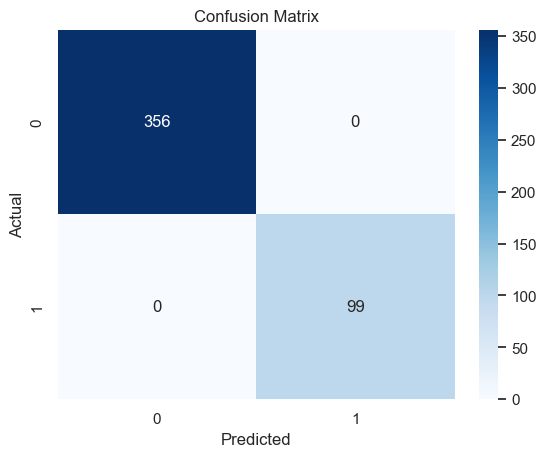

In [41]:
# Predict on the test set
y_pred = best_rf.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [42]:
# test the model on a new dataset
import pandas as pd
import os

# Path to your new dataset (replace with actual path if necessary)


# Load new dataset files
gold_df = pd.read_csv('gold_prices.csv')
silver_df = pd.read_csv('silver_prices.csv')

# Convert the 'Date' column to datetime format
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
silver_df['Date'] = pd.to_datetime(silver_df['Date'])

# Merge gold and silver data on 'Date'
df_new = pd.merge(gold_df, silver_df, on='Date', suffixes=('_gold', '_silver'))

# Filter the dataset to include only data from 2019 to 2024
df_new = df_new[(df_new['Date'] >= '2019-01-01') & (df_new['Date'] <= '2024-12-31')]

# Display the first few rows of the filtered dataset
df_new.head()


,Date,Close/Last_gold,Volume_gold,Open_gold,High_gold,Low_gold,Close/Last_silver,Volume_silver,Open_silver,High_silver,Low_silver
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,23.042,11441.0,22.800,23.385,22.725
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,22.856,10802.0,22.905,23.170,22.770
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,22.656,60396.0,22.650,22.770,22.265
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,22.708,51908.0,22.740,22.820,22.410
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,22.743,48043.0,22.760,22.910,22.610


In [43]:
# Calculate the Gold-Silver Ratio
df_new['Gold_Silver_Ratio'] = df_new['Close/Last_gold'] / df_new['Close/Last_silver']

# Create moving averages for additional features (5-day and 20-day moving averages)
df_new['Gold_5_MA'] = df_new['Close/Last_gold'].rolling(window=5).mean()
df_new['Silver_5_MA'] = df_new['Close/Last_silver'].rolling(window=5).mean()
df_new['Gold_20_MA'] = df_new['Close/Last_gold'].rolling(window=20).mean()
df_new['Silver_20_MA'] = df_new['Close/Last_silver'].rolling(window=20).mean()

# Drop rows with NaN values caused by rolling calculations
df_new = df_new.dropna()

# Define the features (same as used in the training data)
X_new = df_new[['Gold_Silver_Ratio', 'Gold_5_MA', 'Silver_5_MA', 'Gold_20_MA', 'Silver_20_MA']]


C:\Users\Leo\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Leo\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Leo\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision

Accuracy on New Dataset: 0.5092674315975286

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       556
           1       0.51      1.00      0.67       577

    accuracy                           0.51      1133
   macro avg       0.25      0.50      0.34      1133
weighted avg       0.26      0.51      0.34      1133


Confusion Matrix:
 [[  0 556]
 [  0 577]]


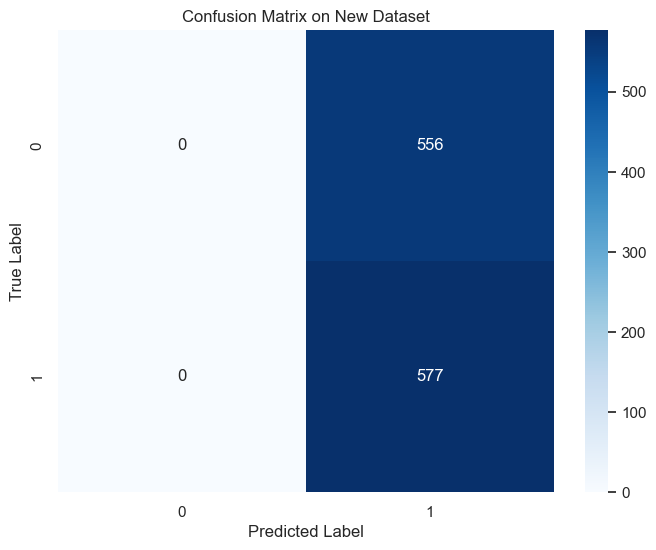

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the existing trained model to make predictions
y_pred_new = best_rf.predict(X_new)

threshold = df_new['Gold_Silver_Ratio'].mean()  # Adjust threshold if needed
df_new['Swap_Gold_for_Silver'] = np.where(df_new['Gold_Silver_Ratio'] > threshold, 1, 0)
# If you have the target variable for the new dataset, load it as `y_new`
# For demonstration, assuming `y_new` is available
y_new = df_new['Swap_Gold_for_Silver']  # Replace with actual target column if available

# Calculate accuracy
print("Accuracy on New Dataset:", accuracy_score(y_new, y_pred_new))

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_new, y_pred_new))
print("\nConfusion Matrix:\n", confusion_matrix(y_new, y_pred_new))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_new, y_pred_new), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on New Dataset")
plt.show()
